# Executive Summary

For the task of predicting the attribute value for occasion category, I tried out two methods. For the first method, I built individual models for each attribute value separately. I first separated out the data (including lables) for 7 attribute values and trained them separately. During the training process, I tested out several techniques:
- Neural Network
- Glove embedding & LSTM
- W2V embedding & LSTM
- Glove embedding & RNN

From the validation and test performance, I found that neural network and LSTM with Glove has better performance than the rest. Between nerual network and LSTM with Glove, for most attribute values, neural network has a slighly better performance and takes much less time to train. In addition, comparing Glove with W2V embedding, I found that Glove has a better performance for LSTM model. However, after evaluating the class balancedness for each attribute value, I realized that even the best one (neural network) only worked slightly better than simply predicting 1 or 0 (1-4% accuracy higher). Therefore, I decided to try the second method: one hot encoding for the attribute values and predict probability for each value. Inspired by previous process and due to the time constraint, I decided to use Glove embedding and neural network. The performance is better than the first method, so it is selected as my final model.

For the input features, I first used all of information (brand, name, details, description). Then I dropped detail column and only use brand, name and description. I trained LSTM with these two combinations and found that the performance didn't differ much with each other. After browsing details columns, I felt that it didn't contain much additional information for tag prediction (given brand, name and description). Therefore, in order to speed up training process and improve efficiency, I finally chose brand, name and description to be my training input.

# Final method

In [33]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from gensim.test.utils import get_tmpfile 
from gensim.models import Word2Vec
from nltk import word_tokenize
import pandas as pd
import numpy as np
import keras
import spacy
import en_core_web_md
import warnings
from numpy import array, argmax, asarray, zeros
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Sequential
from keras.layers import Dense, Embedding, Flatten, Masking, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from random import randint
from keras import optimizers
from keras.layers.recurrent import SimpleRNN, LSTM
from matplotlib import pyplot as plt
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

In [34]:
pd.set_option('display.max_colwidth', -1)

data = pd.read_csv("occ_cleaned.csv")
#data.head()

In [35]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def clean(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_num = re.sub('[0-9]+', '', cleantext)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    return " ".join(stem_words)


data['description']=data['description'].map(lambda s: clean(s))
data['details'] = data['details'].map(lambda s: clean(s))
data['name'] = data['name'].map(lambda s: clean(s))

In [36]:
data.head()

,product_id,attribute_name,attribute_value,brand,description,details,name
0,01DVS1SHB0MXNERKX17C3P5YXS,occasion,weekend,mansurgavriel,mansur gavriel sleek mini top handl bag craft itali soft calfskin crescent shape top minim look allow maximum versatil make viabl option pair dress tailor look alik,zip fasten across top composit calf leather made itali bag measur height wide depth,mini leather top handl bag
1,01DVS1SHB0MXNERKX17C3P5YXS,occasion,weekend,mansurgavriel,mansur gavriel sleek mini top handl bag craft itali soft calfskin crescent shape top minim look allow maximum versatil make viabl option pair dress tailor look alik,zip fasten across top composit calf leather made itali bag measur height wide depth,mini leather top handl bag
2,01DPEEZGRJYX4N4WE78GPM0B2G,occasion,weekend,jcrew,meet new favorit everyday ankl boot mdash soft sued goe great fall floral crop denim ever satisfi crunch step fallen leav,unknown_token,sadi boot sued
3,01DTJ8EMCR26JCYAWK0CYST9H7,occasion,daytonight,marni,everyth want structur everyday bag glorious spaciou size option crossbodi strap conveni storag compart thing classic tri color leather classic plu zip shut especi travel subway metro friendli leather brassheight width depth made itali,unknown_token,law bag shoulder bag
4,01E1JKZ7CJ8A3C1PPM0QCAEDGY,occasion,work,veronicabeard,made highest qualiti japanes stretch denim high rise skinni boast flatter fit fantast shape recoveri,high rise true size sizevalu sizevalu sizevalu sizevalu sizevalu sizevalu sizevalu sizevalu sizevalu,kate skinni jean


In [37]:
# one-hot encoding for all possible attribute values
# during the data cleaning part, I already combined values like day to night and daytonight into daytonight, etc.
dummies = pd.get_dummies(data['attribute_value'])
dummies.head()

,coldweather,daytonight,nightout,vacation,weekend,work,workout
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0


In [38]:
data = pd.concat([data, dummies], axis=1, sort=False)

In [39]:
# combine the result for duplicated product_ids (in different rows)
sumdata = data.groupby('product_id').agg({'coldweather':'sum','daytonight':'sum','nightout':'sum','vacation':'sum','weekend':'sum','work':'sum','workout':'sum'}).reset_index()
df = data.iloc[:,:7].merge(sumdata,left_on='product_id',right_on='product_id')
df.drop_duplicates(subset =["product_id"],keep = "first",inplace = True) 
df.shape

(3914, 14)

In [40]:
df['feature'] = df[['brand','name','description']].apply(lambda x: " ".join(x.astype(str)),axis=1)
df.drop(['attribute_name','attribute_value','brand','description','details','name'],axis=1,inplace=True)
docs = df['feature']

# to change values larger than 1 to 1 (for binary classification)
df['coldweather'] = df['coldweather'].apply(lambda x: 1 if x >0 else 0)
df['daytonight'] = df['daytonight'].apply(lambda x: 1 if x >0 else 0)
df['nightout'] = df['nightout'].apply(lambda x: 1 if x >0 else 0)
df['vacation'] = df['vacation'].apply(lambda x: 1 if x >0 else 0)
df['weekend'] = df['weekend'].apply(lambda x: 1 if x >0 else 0)
df['work'] = df['work'].apply(lambda x: 1 if x >0 else 0)
df['workout'] = df['workout'].apply(lambda x: 1 if x >0 else 0)
#df.head()
labels = df.iloc[:,1:8]

In [41]:
X = docs
y = labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
# fit tokenizer on training data
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [43]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [44]:
# obtain embedding matrix with Glove
EMBEDDING_SIZE = 100
embedding_matrix = zeros((vocab_size, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [45]:
def get_max_token_length_per_doc(docs):
    return max(list(map(lambda x: len(x.split()), docs)))

max_seq_length = get_max_token_length_per_doc(docs)

In [46]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

In [47]:
X_train_encoded = integer_encode_documents(X_train, tokenizer)
X_test_encoded = integer_encode_documents(X_test, tokenizer)

In [48]:
# padding inputs
X_train_padded = pad_sequences(X_train_encoded, padding='post', maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_encoded, padding='post', maxlen=max_seq_length)

In [65]:
# Build neural network model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(Flatten())
model.add(Dense(128,activation='tanh'))
#model.add(Dense(64, activation='tanh'))
model.add(Dense(7, activation='sigmoid'))
# add in early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint("model.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [66]:
history = model.fit(X_train_padded, y_train, validation_split=0.1, epochs=50, verbose=1, callbacks=[es,mc])

Train on 2817 samples, validate on 314 samples
Epoch 1/50
2817/2817 [==============================] - 2s 853us/step - loss: 0.4350 - acc: 0.8097 - val_loss: 0.4137 - val_acc: 0.8176
Epoch 2/50
2817/2817 [==============================] - 2s 781us/step - loss: 0.2994 - acc: 0.8738 - val_loss: 0.4239 - val_acc: 0.8116
Epoch 3/50
2817/2817 [==============================] - 2s 693us/step - loss: 0.2355 - acc: 0.9032 - val_loss: 0.4619 - val_acc: 0.8135
Epoch 4/50
2817/2817 [==============================] - 2s 666us/step - loss: 0.1933 - acc: 0.9258 - val_loss: 0.4841 - val_acc: 0.8089
Epoch 5/50
2817/2817 [==============================] - 2s 677us/step - loss: 0.1588 - acc: 0.9418 - val_loss: 0.5179 - val_acc: 0.8121
Epoch 6/50
2817/2817 [==============================] - 2s 686us/step - loss: 0.1295 - acc: 0.9548 - val_loss: 0.5463 - val_acc: 0.8076
Epoch 7/50
2817/2817 [==============================] - 2s 710us/step - loss: 0.1004 - acc: 0.9713 - val_loss: 0.5763 - val_acc: 0.8135
E

In [67]:
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print("Test Accuracy:", accuracy)

783/783 [==============================] - 0s 171us/step
Test Accuracy: 0.8029555082321167


In [68]:
cols = ["coldweather","daytonight","nightout","vacation","weekend","work","workout"]
pred = model.predict(X_test_padded)
result = pd.DataFrame(data= pred, columns = cols, index=X_test.index)
#result

In [69]:
# set the threshold to be 0.49
for c in cols:
    result[c]=result[c].apply(lambda x: 1 if x>0.49 else 0)

In [70]:
result

,coldweather,daytonight,nightout,vacation,weekend,work,workout
4613,0,0,1,0,0,0,0
462,0,1,0,0,1,0,1
11214,0,1,0,0,1,0,0
1678,0,1,0,0,1,0,0
11925,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...
3595,0,0,0,0,1,0,0
6814,0,1,0,0,1,0,0
4483,0,1,1,0,0,1,0
8070,0,1,1,0,0,0,0


# Apply model to the full data

In [190]:
full = pd.read_csv("Full data.csv")
extra = pd.read_csv("extra_data.csv")
ff = pd.concat([full, extra], axis=0)
keep_cols = ['product_id','brand','description','details','name']
ff = ff[keep_cols]

In [191]:
ff['description']=data['description'].map(lambda s: clean(s))
ff['details'] = data['details'].map(lambda s: clean(s))
ff['name'] = data['name'].map(lambda s: clean(s))

In [192]:
ff['feature'] = ff[['brand','name','description']].apply(lambda x: " ".join(x.astype(str)),axis=1)
#ff.head()

In [193]:
docs=ff['feature']

In [194]:
# use the same tokenizer previously fitted on the training text
# replace the vocabulary out of the training set to be UNKNOWN_TOKEN
def oov(doc):
    new =[]
    for word in word_tokenize(doc):
        if word in tokenizer.word_index.keys():
            new.append(word)
        else:
            new.append("UNKNOWN_TOKEN")
    return " ".join(new)
docs = docs.apply(oov)

In [195]:
encoded = integer_encode_documents(docs, tokenizer)
padded_doc = pad_sequences(encoded, padding='post', maxlen=max_seq_length, truncating='post')

In [196]:
ff = ff.set_index("product_id")

In [197]:
prediction = model.predict(padded_doc)
full_predict = pd.DataFrame(data= prediction, columns = cols, index=ff.index)

In [198]:
for c in cols:
    full_predict[c]=full_predict[c].apply(lambda x: 1 if x>0.49 else 0)

In [199]:
#full_predict

In [200]:
tag = []
for i in full_predict.index:
    value = []
    for col in cols:
        if full_predict.loc[i,col].any():
            value.append(col)
    tag.append(value)
full_predict['Occasion'] = tag
#full_predict

In [157]:
occ = full_predict.iloc[:,[7]]
#occ = occ.reset_index().sort_values("product_id")

In [204]:
full = full.iloc[:,:14]
df = pd.concat([full, extra], axis=0)
o = occ.reset_index()
df['occ'] = o.Occasion
df.to_csv("group_silver_occasion_data.csv")

## Testing Function

In [213]:
def predict_occasion(brand,name,description):
    tag = []
    text = str(brand) + str(name) + str(description)
    text = oov(text)
    encoded = integer_encode_documents(text, tokenizer)
    padded_doc = pad_sequences(encoded, padding='post', maxlen=max_seq_length, truncating='post')
    
    prediction = model.predict(padded_doc)
    df = pd.DataFrame(data= prediction, columns = cols)

    for i in df.index:
        value = []
        for col in cols:
            if df.loc[i,col]>0.49:
                value.append(col)
        #tag.append(value)
    #full_predict['Occasion'] = tag
    return value

In [214]:
predict_occasion("mansurgavriel","mini leather top handl bag","mansur gavriel sleek mini top handl bag craft itali soft calfskin crescent shape top minim look allow maximum versatil make viabl option pair dress tailor look alik")

['daytonight', 'weekend']

# Appendix - methods tried (partially)

## First method: build individual models

In [5]:
data = pd.read_csv("occ_cleaned.csv")
all_value = data.groupby('product_id')['attribute_value'].unique().reset_index()
all_value.head()

,product_id,attribute_value
0,01DPC9GSTT72KHNN0MNDNKH7RD,"[daytonight, work]"
1,01DPCB2KEAVXXKFVM7FXBNE4VY,"[daytonight, weekend, work]"
2,01DPCG1C1P0MQAV9NMS3N1TDAA,"[weekend, nightout]"
3,01DPCHNEW5F2RHJQ3NJMVPK6SE,"[work, daytonight, weekend]"
4,01DPCHNQM0PA0SXZZZX85PF2ZJ,"[daytonight, weekend]"


### label=1

In [6]:
wkd = all_value[all_value['attribute_value'].apply(lambda x: 'weekend' in x)]
wkd = pd.merge(wkd, data, how='left', on='product_id')
wkd = wkd.iloc[:,3:]
wkd.columns = ['label','brand','description','details','name']
wkd = wkd[wkd.label=='weekend']
wkd.drop_duplicates(inplace=True)

In [7]:
dtn = all_value[all_value['attribute_value'].apply(lambda x: 'daytonight' in x)]
dtn = pd.merge(dtn, data, how='left', on='product_id')
dtn = dtn.iloc[:,3:]
dtn.columns = ['label','brand','description','details','name']
dtn = dtn[dtn.label=='daytonight']
dtn.drop_duplicates(inplace=True)

In [8]:
work = all_value[all_value['attribute_value'].apply(lambda x: 'work' in x)]
work = pd.merge(work, data, how='left', on='product_id')
work = work.iloc[:,3:]
work.columns = ['label','brand','description','details','name']
work = work[work.label=='work']
work.drop_duplicates(inplace=True)

In [9]:
ntot = all_value[all_value['attribute_value'].apply(lambda x: 'nightout' in x)]
ntot = pd.merge(ntot, data, how='left', on='product_id')
ntot = ntot.iloc[:,3:]
ntot.columns = ['label','brand','description','details','name']
ntot = ntot[ntot.label=='nightout']
ntot.drop_duplicates(inplace=True)

In [10]:
vc = all_value[all_value['attribute_value'].apply(lambda x: 'vacation' in x)]
vc = pd.merge(vc, data, how='left', on='product_id')
vc = vc.iloc[:,3:]
vc.columns = ['label','brand','description','details','name']
vc = vc[vc.label=='vacation']
vc.drop_duplicates(inplace=True)

In [11]:
wkot = all_value[all_value['attribute_value'].apply(lambda x: 'workout' in x)]
wkot = pd.merge(wkot, data, how='left', on='product_id')
wkot = wkot.iloc[:,3:]
wkot.columns = ['label','brand','description','details','name']
wkot = wkot[wkot.label=='workout']
wkot.drop_duplicates(inplace=True)

In [12]:
cw = all_value[all_value['attribute_value'].apply(lambda x: 'coldweather' in x)]
cw = pd.merge(cw, data, how='left', on='product_id')
cw = cw.iloc[:,3:]
cw.columns = ['label','brand','description','details','name']
cw = cw[cw.label=='coldweather']
cw.drop_duplicates(inplace=True)

### label = 0

In [13]:
nwkd = all_value[all_value['attribute_value'].apply(lambda x: 'weekend' not in x)]
nwkd = pd.merge(nwkd, data, how='left', on='product_id')
nwkd = nwkd.iloc[:,3:]
nwkd.columns = ['label','brand','description','details','name']
nwkd['label'] = 0
nwkd.drop_duplicates(inplace=True)

In [14]:
ndtn = all_value[all_value['attribute_value'].apply(lambda x: 'daytonight' not in x)]
ndtn = pd.merge(ndtn, data, how='left', on='product_id')
ndtn = ndtn.iloc[:,3:]
ndtn.columns = ['label','brand','description','details','name']
ndtn['label'] = 0
ndtn.drop_duplicates(inplace=True)

In [15]:
nwork = all_value[all_value['attribute_value'].apply(lambda x: 'work' not in x)]
nwork = pd.merge(nwork, data, how='left', on='product_id')
nwork = nwork.iloc[:,3:]
nwork['label'] = 0
nwork.drop_duplicates(inplace=True)

In [16]:
nntot = all_value[all_value['attribute_value'].apply(lambda x: 'nightout' not in x)]
nntot = pd.merge(nntot, data, how='left', on='product_id')
nntot = nntot.iloc[:,3:]
nntot.columns = ['label','brand','description','details','name']
nntot['label'] = 0
nntot.drop_duplicates(inplace=True)

In [17]:
nvc = all_value[all_value['attribute_value'].apply(lambda x: 'vacation' not in x)]
nvc = pd.merge(nvc, data, how='left', on='product_id')
nvc = nvc.iloc[:,3:]
nvc.columns = ['label','brand','description','details','name']
nvc['label'] = 0
nvc.drop_duplicates(inplace=True)

In [18]:
nwkot = all_value[all_value['attribute_value'].apply(lambda x: 'workout' not in x)]
nwkot = pd.merge(nwkot, data, how='left', on='product_id')
nwkot = nwkot.iloc[:,3:]
nwkot.columns = ['label','brand','description','details','name']
nwkot['label'] = 0
nwkot.drop_duplicates(inplace=True)

In [19]:
ncw = all_value[all_value['attribute_value'].apply(lambda x: 'coldweather' not in x)]
ncw = pd.merge(ncw, data, how='left', on='product_id')
ncw = ncw.iloc[:,3:]
ncw.columns = ['label','brand','description','details','name']
ncw['label'] = 0
ncw.drop_duplicates(inplace=True)

In [20]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

def preprocessing(data1,data0):
    # concatenate columns
    data1['features'] = data1[['brand','name','description']].apply(lambda x: " ".join(x.astype(str)),axis=1)
    data0['features'] = data0[['brand','name','description']].apply(lambda x: " ".join(x.astype(str)),axis=1)
    num_1 = len(data1['features'])
    num_0 = len(data0['features'])
    
    # get docs and labels
    docs = data1['features'].tolist() + data0['features'].tolist()
    labels = np.concatenate([np.ones(num_1), np.zeros(num_0)])
    
    nlp = en_core_web_md.load()
    stopwords_removed_docs = list(
        map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))
    
    return stopwords_removed_docs, labels

In [33]:
def encoding(stopwords_removed_docs, labels):
    tokenizer = Tokenizer(num_words=2000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(stopwords_removed_docs)
    encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)
    MAX_SEQUENCE_LENGTH = len(max(stopwords_removed_docs,key=len))
    padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    
    encoder = LabelEncoder()
    labels = to_categorical(encoder.fit_transform(labels))
    
    #X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)
    
    
    #return X_train, X_test, y_train, y_test
    return padded_docs, labels

In [23]:
def glove_embedding(stopwords_removed_docs):
    tokenizer = Tokenizer(num_words=2000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(stopwords_removed_docs)
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
    
    MAX_SEQUENCE_LENGTH = len(max(stopwords_removed_docs,key=len))

    embeddings_index = load_glove_vectors()
    
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, VOCAB_SIZE, MAX_SEQUENCE_LENGTH

In [24]:
def w2v_embedding(stopwords_removed_docs, data1, data0):
    tokenizer = Tokenizer(num_words=2000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(stopwords_removed_docs)
    
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.3)
    MAX_SEQUENCE_LENGTH = len(max(stopwords_removed_docs,key=len))

    data1['features'] = data1[['brand','name','description']].apply(lambda x: " ".join(x.astype(str)),axis=1)
    data0['features'] = data0[['brand','name','description']].apply(lambda x: " ".join(x.astype(str)),axis=1)
    num_1 = len(data1['features'])
    num_0 = len(data0['features'])
    
    features = data1['features'].tolist() + data0['features'].tolist()
    w2vdocs = [word_tokenize(f) for f in features]
    w2vmodel = Word2Vec(w2vdocs, size=100, window=3, min_count=5, workers=4)
    
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if word in w2vmodel:
            embedding_matrix[i] = w2vmodel[word]
    return embedding_matrix, VOCAB_SIZE, MAX_SEQUENCE_LENGTH

In [25]:
def make_lstm_classification_model(model_name, VOCAB_SIZE, MAX_SEQUENCE_LENGTH, embedding_matrix, plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    ''' model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))'''
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    name = model_name+".h5"
    mc = ModelCheckpoint(name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # Compile the model
    model.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, es, mc

In [34]:
def make_nn_classification_model(model_name, vocab_size, MAX_SEQUENCE_LENGTH):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Flatten()) 
    model.add(Dense(128, activation='tanh')) 
    model.add(Dense(2, activation='sigmoid')) 
    
    # early stopping
    name = model_name+".h5"
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint(name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model, es, mc
    
    #opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    
def nn_model(data1,data0,model_name):
    stopwords_removed_docs, labels = preprocessing(data1,data0)
    padded_docs, labels= encoding(stopwords_removed_docs,labels)
    X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)
    tk = Tokenizer(oov_token = 'UNKNOWN_TOKEN')
    tk.fit_on_texts(stopwords_removed_docs)
    vocab_size = len(tk.word_index) + 1
    encoded_docs = integer_encode_documents(stopwords_removed_docs, tk)
    MAX_SEQUENCE_LENGTH = len(max(stopwords_removed_docs,key=len))

    model, es, mc = make_nn_classification_model(model_name, vocab_size, MAX_SEQUENCE_LENGTH)
    history = model.fit(X_train, y_train,validation_split = 0.1, epochs=20, verbose=1, callbacks=[es,mc])
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    #print("================ON TEST SET===============")
    #print('Test accuracy: %f' % (accuracy*100))
    #plot_fit_history(history)
    return model

In [28]:
def lstm_model(data1,data0,model_name):
    stopwords_removed_docs, labels = preprocessing(data1,data0)
    X_train, X_test, y_train, y_test= encoding(stopwords_removed_docs,labels)
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    embedding_matrix, VOCAB_SIZE, MAX_SEQUENCE_LENGTH = glove_embedding(stopwords_removed_docs)
    model, es, mc = make_lstm_classification_model(model_name, VOCAB_SIZE, MAX_SEQUENCE_LENGTH, embedding_matrix)
    history = model.fit(X_train, y_train,validation_split = 0.1, epochs=100, verbose=1, callbacks=[es,mc])
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("================ON TEST SET===============")
    print('Test accuracy: %f' % (accuracy*100))
    plot_fit_history(history)
    #return model

In [29]:
def rnn_model(data1,data0,model_name):
    stopwords_removed_docs, labels = preprocessing(data1,data0)
    X_train, X_test, y_train, y_test= encoding(stopwords_removed_docs,labels)
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    embedding_matrix, VOCAB_SIZE, MAX_SEQUENCE_LENGTH = glove_embedding(stopwords_removed_docs)
    model, es, mc = make_binary_classification_rnn_model(model_name, VOCAB_SIZE, MAX_SEQUENCE_LENGTH, embedding_matrix)
    history = model.fit(X_train, y_train,validation_split = 0.1, epochs=10, verbose=1, callbacks=[es,mc])
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("================ON TEST SET===============")
    print('Test accuracy: %f' % (accuracy*100))
    plot_fit_history(history)
    #return model

In [30]:
def lstm_w2v(data1,data0,model_name):
    stopwords_removed_docs, labels = preprocessing(data1,data0)
    X_train, X_test, y_train, y_test= encoding(stopwords_removed_docs,labels)
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    embedding_matrix, VOCAB_SIZE, MAX_SEQUENCE_LENGTH = w2v_embedding(stopwords_removed_docs, data1, data0)
    model, es, mc = make_lstm_classification_model(model_name, VOCAB_SIZE, MAX_SEQUENCE_LENGTH, embedding_matrix)
    history = model.fit(X_train, y_train,validation_split = 0.1, epochs=8, verbose=1, callbacks=[es,mc])
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("================ON TEST SET===============")
    print('Test accuracy: %f' % (accuracy*100))
    plot_fit_history(history)
    #return model

## Using neural network

Train on 2757 samples, validate on 307 samples
Epoch 1/100
2757/2757 [==============================] - 12s 4ms/step - loss: 0.6323 - accuracy: 0.7483 - val_loss: 0.5141 - val_accuracy: 0.7850

Epoch 00001: val_accuracy improved from -inf to 0.78502, saving model to wkd_nn.h5
Epoch 2/100
2757/2757 [==============================] - 12s 4ms/step - loss: 0.4361 - accuracy: 0.8032 - val_loss: 0.4135 - val_accuracy: 0.8192

Epoch 00002: val_accuracy improved from 0.78502 to 0.81922, saving model to wkd_nn.h5
Epoch 3/100
2757/2757 [==============================] - 12s 4ms/step - loss: 0.1805 - accuracy: 0.9369 - val_loss: 0.4498 - val_accuracy: 0.8062

Epoch 00003: val_accuracy did not improve from 0.81922
Epoch 4/100
2757/2757 [==============================] - 12s 4ms/step - loss: 0.0799 - accuracy: 0.9764 - val_loss: 0.4940 - val_accuracy: 0.8029

Epoch 00004: val_accuracy did not improve from 0.81922
Epoch 5/100
2757/2757 [==============================] - 14s 5ms/step - loss: 0.0626 -

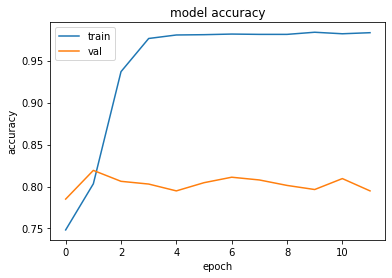

In [98]:
nn_model(wkd,nwkd,"wkd_nn")

Train on 2757 samples, validate on 307 samples
Epoch 1/100
2757/2757 [==============================] - 17s 6ms/step - loss: 0.9107 - accuracy: 0.7018 - val_loss: 0.5208 - val_accuracy: 0.7443

Epoch 00001: val_accuracy improved from -inf to 0.74430, saving model to dtn_nn.h5
Epoch 2/100
2757/2757 [==============================] - 15s 6ms/step - loss: 0.3855 - accuracy: 0.8322 - val_loss: 0.5063 - val_accuracy: 0.7508

Epoch 00002: val_accuracy improved from 0.74430 to 0.75081, saving model to dtn_nn.h5
Epoch 3/100
2757/2757 [==============================] - 16s 6ms/step - loss: 0.1762 - accuracy: 0.9438 - val_loss: 0.5925 - val_accuracy: 0.7150

Epoch 00003: val_accuracy did not improve from 0.75081
Epoch 4/100
2757/2757 [==============================] - 14s 5ms/step - loss: 0.0839 - accuracy: 0.9771 - val_loss: 0.6934 - val_accuracy: 0.7101

Epoch 00004: val_accuracy did not improve from 0.75081
Epoch 5/100
2757/2757 [==============================] - 16s 6ms/step - loss: 0.0588 -

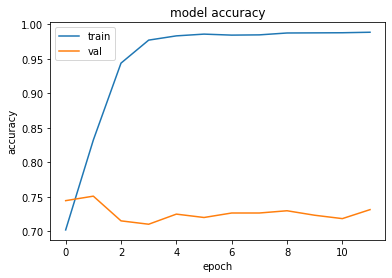

In [99]:
nn_model(dtn,ndtn,"dtn_nn")

Train on 4712 samples, validate on 524 samples
Epoch 1/100
4712/4712 [==============================] - 21s 4ms/step - loss: 0.5865 - accuracy: 0.8096 - val_loss: 0.3396 - val_accuracy: 0.8664

Epoch 00001: val_accuracy improved from -inf to 0.86641, saving model to work_nn.h5
Epoch 2/100
4712/4712 [==============================] - 22s 5ms/step - loss: 0.2453 - accuracy: 0.9055 - val_loss: 0.3175 - val_accuracy: 0.8626

Epoch 00002: val_accuracy did not improve from 0.86641
Epoch 3/100
4712/4712 [==============================] - 24s 5ms/step - loss: 0.1003 - accuracy: 0.9660 - val_loss: 0.2946 - val_accuracy: 0.8912

Epoch 00003: val_accuracy improved from 0.86641 to 0.89122, saving model to work_nn.h5
Epoch 4/100
4712/4712 [==============================] - 22s 5ms/step - loss: 0.0460 - accuracy: 0.9851 - val_loss: 0.3429 - val_accuracy: 0.8960

Epoch 00004: val_accuracy improved from 0.89122 to 0.89599, saving model to work_nn.h5
Epoch 5/100
4712/4712 [=============================

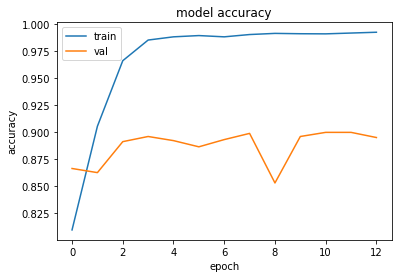

In [100]:
nn_model(work,nwork,"work_nn")

Train on 2752 samples, validate on 306 samples
Epoch 1/100
2752/2752 [==============================] - 14s 5ms/step - loss: 0.6516 - accuracy: 0.7426 - val_loss: 0.4193 - val_accuracy: 0.8007

Epoch 00001: val_accuracy improved from -inf to 0.80065, saving model to ntot_nn.h5
Epoch 2/100
2752/2752 [==============================] - 14s 5ms/step - loss: 0.3167 - accuracy: 0.8625 - val_loss: 0.3968 - val_accuracy: 0.8056

Epoch 00002: val_accuracy improved from 0.80065 to 0.80556, saving model to ntot_nn.h5
Epoch 3/100
2752/2752 [==============================] - 13s 5ms/step - loss: 0.1281 - accuracy: 0.9624 - val_loss: 0.4623 - val_accuracy: 0.8023

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/100
2752/2752 [==============================] - 12s 4ms/step - loss: 0.0623 - accuracy: 0.9836 - val_loss: 0.4902 - val_accuracy: 0.8088

Epoch 00004: val_accuracy improved from 0.80556 to 0.80882, saving model to ntot_nn.h5
Epoch 5/100
2752/2752 [=============================

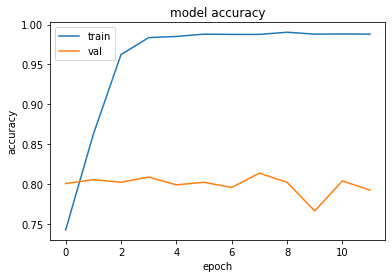

In [101]:
nn_model(ntot,nntot,"ntot_nn")

Train on 2753 samples, validate on 306 samples
Epoch 1/100
2753/2753 [==============================] - 13s 5ms/step - loss: 0.7177 - accuracy: 0.8273 - val_loss: 0.4591 - val_accuracy: 0.8072

Epoch 00001: val_accuracy improved from -inf to 0.80719, saving model to vc_nn.h5
Epoch 2/100
2753/2753 [==============================] - 12s 4ms/step - loss: 0.3373 - accuracy: 0.8612 - val_loss: 0.3665 - val_accuracy: 0.8366

Epoch 00002: val_accuracy improved from 0.80719 to 0.83660, saving model to vc_nn.h5
Epoch 3/100
2753/2753 [==============================] - 16s 6ms/step - loss: 0.1695 - accuracy: 0.9312 - val_loss: 0.3812 - val_accuracy: 0.8268

Epoch 00003: val_accuracy did not improve from 0.83660
Epoch 4/100
2753/2753 [==============================] - 15s 6ms/step - loss: 0.0831 - accuracy: 0.9691 - val_loss: 0.5101 - val_accuracy: 0.8268

Epoch 00004: val_accuracy did not improve from 0.83660
Epoch 5/100
2753/2753 [==============================] - 16s 6ms/step - loss: 0.0610 - a

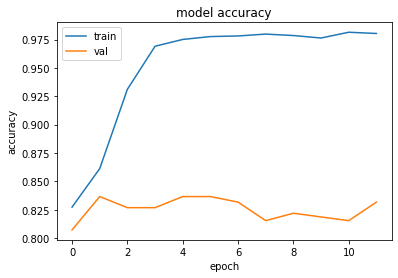

In [102]:
nn_model(vc,nvc,"vc_nn")

Train on 2752 samples, validate on 306 samples
Epoch 1/100
2752/2752 [==============================] - 12s 4ms/step - loss: 0.3307 - accuracy: 0.9346 - val_loss: 0.1614 - val_accuracy: 0.9673

Epoch 00001: val_accuracy improved from -inf to 0.96732, saving model to cw_nn.h5
Epoch 2/100
2752/2752 [==============================] - 11s 4ms/step - loss: 0.2296 - accuracy: 0.9390 - val_loss: 0.1665 - val_accuracy: 0.9673

Epoch 00002: val_accuracy did not improve from 0.96732
Epoch 3/100
2752/2752 [==============================] - 11s 4ms/step - loss: 0.2340 - accuracy: 0.9390 - val_loss: 0.1479 - val_accuracy: 0.9673

Epoch 00003: val_accuracy did not improve from 0.96732
Epoch 4/100
2752/2752 [==============================] - 11s 4ms/step - loss: 0.2323 - accuracy: 0.9390 - val_loss: 0.1522 - val_accuracy: 0.9673

Epoch 00004: val_accuracy did not improve from 0.96732
Epoch 5/100
2752/2752 [==============================] - 12s 4ms/step - loss: 0.2306 - accuracy: 0.9390 - val_loss: 0.

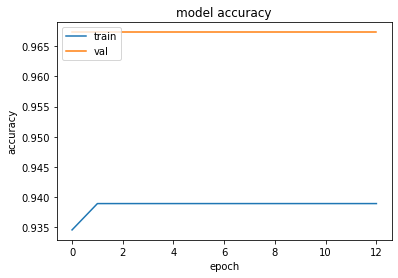

In [103]:
nn_model(cw,ncw,"cw_nn")

Train on 2746 samples, validate on 306 samples
Epoch 1/100
2746/2746 [==============================] - 11s 4ms/step - loss: 0.2185 - accuracy: 0.9545 - val_loss: 0.1285 - val_accuracy: 0.9739

Epoch 00001: val_accuracy improved from -inf to 0.97386, saving model to wkot_nn.h5
Epoch 2/100
2746/2746 [==============================] - 11s 4ms/step - loss: 0.1690 - accuracy: 0.9599 - val_loss: 0.1233 - val_accuracy: 0.9739

Epoch 00002: val_accuracy did not improve from 0.97386
Epoch 3/100
2746/2746 [==============================] - 14s 5ms/step - loss: 0.1686 - accuracy: 0.9599 - val_loss: 0.1222 - val_accuracy: 0.9739

Epoch 00003: val_accuracy did not improve from 0.97386
Epoch 4/100
2746/2746 [==============================] - 17s 6ms/step - loss: 0.1688 - accuracy: 0.9599 - val_loss: 0.1279 - val_accuracy: 0.9739

Epoch 00004: val_accuracy did not improve from 0.97386
Epoch 5/100
2746/2746 [==============================] - 15s 5ms/step - loss: 0.1693 - accuracy: 0.9599 - val_loss: 

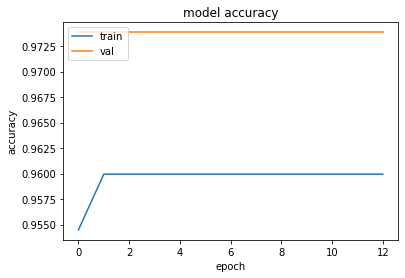

In [104]:
nn_model(wkot,nwkot,"wkot_nn")

## Using LSTM with Glove

Loaded 400000 word vectors.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 620, 100)          590000    
_________________________________________________________________
masking_2 (Masking)          (None, 620, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)       

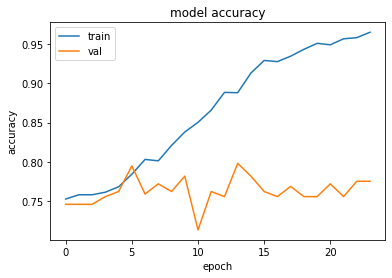

In [43]:
lstm_model(wkd,nwkd,"wkd")

Loaded 400000 word vectors.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 620, 100)          590000    
_________________________________________________________________
masking_3 (Masking)          (None, 620, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)       

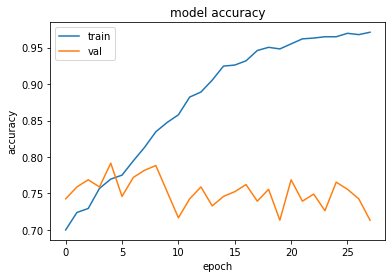

In [44]:
lstm_model(dtn,ndtn,"dtn")

Loaded 400000 word vectors.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 620, 100)          590000    
_________________________________________________________________
masking_4 (Masking)          (None, 620, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)       

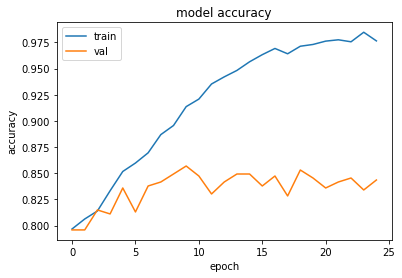

In [45]:
lstm_model(work,nwork,"work")

Loaded 400000 word vectors.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 620, 100)          590000    
_________________________________________________________________
masking_5 (Masking)          (None, 620, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)      

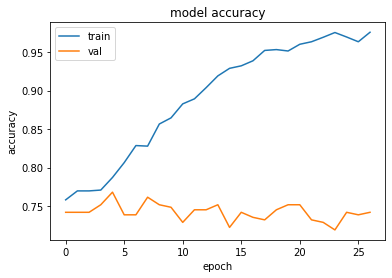

In [46]:
lstm_model(ntot,nntot,"ntot")

Loaded 400000 word vectors.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 620, 100)          590000    
_________________________________________________________________
masking_6 (Masking)          (None, 620, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)      

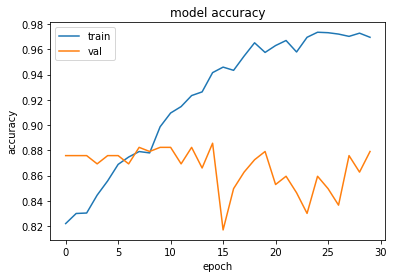

In [47]:
lstm_model(vc,nvc,"vc")

Loaded 400000 word vectors.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 620, 100)          590000    
_________________________________________________________________
masking_7 (Masking)          (None, 620, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)      

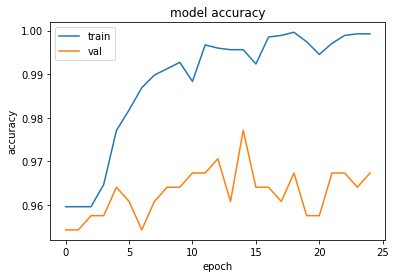

In [48]:
lstm_model(wkot,nwkot,"wkot")

Loaded 400000 word vectors.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 620, 100)          590000    
_________________________________________________________________
masking_8 (Masking)          (None, 620, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_29 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)      

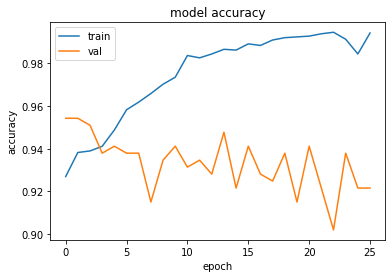

In [49]:
lstm_model(cw,ncw,"cw")